In [33]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [34]:
# Example set size.
M = 30

# Reset pseudo random generator to a known value so that results are reproducible.
np.random.seed(0)

def true_func(M, typef):
    if(typef==0):
        return func0(M)
    elif(typef==1):
        return func1(M)
    else:
        return func0(M)
            
def func0(M):
    x1 = np.sort(6*np.random.rand(M) - 3)
    y = 0.5*x1**2 + x1 + 2
    y_noisy = y + np.random.randn(M)
    # Create test set.
    x1_test = np.linspace(-3, 3, 100).reshape(100, 1)
    y_noisy_test = 0.5*x1_test**2 + x1_test + 2 + np.random.randn(100, 1)
    include_bias = True
    # Polinomial degrees to be tested.
    degrees = [1, 2, 10]
    return x1, y, y_noisy, x1_test, y_noisy_test, include_bias, degrees

def func1(M):
    # Create target function.
    x1 = np.sort(np.random.rand(M))
    y = np.cos(1.5*np.pi*x1)
    y_noisy = y + 0.1*np.random.randn(M)
    # Create test set.
    x1_test = np.linspace(0, 1, 100).reshape(100, 1)
    y_noisy_test = np.cos(1.5*np.pi*x1_test) + 0.1*np.random.randn(100, 1)
    # Indicate if the column of ones is to be included or not.
    include_bias = False
    # Polinomial degrees to be tested.
    degrees = [1, 4, 12]    
    return x1, y, y_noisy, x1_test, y_noisy_test, include_bias, degrees

x1, y, y_noisy, x1_test, y_noisy_test, include_bias, degrees = true_func(M, 0)

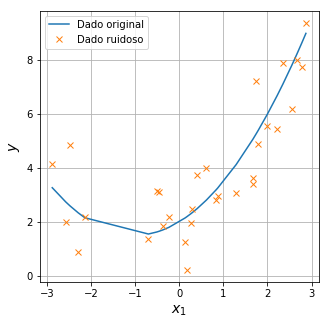

In [35]:
# Plot cost-function surface.
fig = plt.figure(figsize=(5,5))
plt.plot(x1, y, label='Dado original')
plt.plot(x1, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Save figure
plt.savefig("dado_original_versus_ruidoso.png", dpi=600)
#Show the plot.
plt.show()

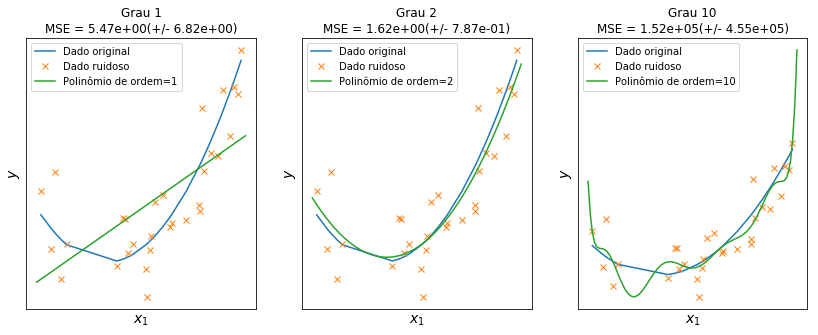

In [36]:
# Reshape arrays so that they become column vectors.
x1 = x1.reshape(M, 1)
y_noisy = y_noisy.reshape(M, 1)

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())    

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    # Perform polynomial regression.
    polynomial_regression.fit(x1, y_noisy)
    
    # Evaluate the models using crossvalidation
    scores = cross_val_score(polynomial_regression, x1, y_noisy, scoring="neg_mean_squared_error", cv=10)    

    # Use the trained model for prediction.
    yp1 = polynomial_regression.predict(x1_test)

    plt.plot(x1, y, label='Dado original')
    plt.plot(x1, y_noisy, 'x', label='Dado ruidoso')
    plt.plot(x1_test, yp1, label='Polinômio de ordem='+str(degrees[i]))
    plt.legend(loc='best')
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$y$', fontsize=14)
    plt.grid()
    plt.title("Grau {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
    
# Save figure
plt.savefig("comparison_different_degrees.png", dpi=600)
#Show the plot.
plt.show()

In [ ]:
# Example set size.
M = 100

# Reset pseudo random generator to a known value so that results are reproducible.
np.random.seed(0)

# Generate true function and noisy version.
x1, y, y_noisy, x1_test, y_noisy_test, include_bias, degrees = true_func(M, 0)

# Reshape arrays so that they become column vectors.
x1 = x1.reshape(M, 1)
y_noisy = y_noisy.reshape(M, 1)

# Split the whole set into random training and validation set.
x1_train, x1_val, y_train, y_val = train_test_split(x1, y_noisy, test_size=0.2, random_state=10)

error_train = []
error_val = []
error_test = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x1_train, y_train, scoring='neg_mean_squared_error', cv=10)
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
    # Perform polynomial regression.
    polynomial_regression.fit(x1_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x1_train)
    
    y_val_predict = polynomial_regression.predict(x1_val)
    
    y_test_predict = polynomial_regression.predict(x1_test)     
    
    error_train.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))

    error_val.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))
    
    error_test.append(np.sqrt(mean_squared_error(y_noisy_test, y_test_predict)))

# Plot results.
plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

ax = plt.subplot(1, 3, 3)
plt.plot(range(1, 13), error_train, label='Erro de trainamento')
plt.plot(range(1, 13), error_val, label='Erro de validação')
plt.plot(range(1, 13), error_test, label='Erro de teste')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Save figure
plt.savefig("model_sel_erro_and_std.png", dpi=600)
#Show the plot.
plt.show()

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    error_test = []
    for m in range(1,len(x1_train)+1):

        # Perform polynomial regression.
        polynomial_regression.fit(x1_train[:m], y_train[:m])

        # Use the trained model for prediction of the training set.
        y_train_predict = polynomial_regression.predict(x1_train[:m])

        # Use the trained model for prediction of the validation set.
        y_val_predict = polynomial_regression.predict(x1_val)
        
        # Use the trained model for prediction of the test set.
        y_test_predict = polynomial_regression.predict(x1_test)        

        # Calculate MSE for training set.
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        # Calculate MSE for validation set.
        error_validation.append(mean_squared_error(y_val, y_val_predict))
        
        # Calculate MSE for test set.
        error_test.append(mean_squared_error(y_noisy_test, y_test_predict))        

    plt.plot(range(1,len(x1_train)+1), np.sqrt(error_training), label='Conjunto de treinamento')
    plt.plot(range(1,len(x1_train)+1), np.sqrt(error_validation), label='Conjunto de validação')
    plt.plot(range(1,len(x1_train)+1), np.sqrt(error_test), label='Conjunto de teste')
    plt.yscale('log')
    plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
    plt.ylabel('Raiz Quadrada do Erro Quadrático Médio', fontsize=14)
    plt.grid()
    plt.ylim([1e-2, 10])
    plt.title('Polinômio de ordem '+str(degrees[i]))
    plt.legend(loc='best')
    
# Save figure
plt.savefig("model_sel_erro_versus_training_set_size.png", dpi=600)
#Show the plot.
plt.show()